# _Finding the best area for a new hotel in Toronto_

# Introduction:

background - 
Toronto, the capital of the province of Ontario, is a major Canadian city along Lake Ontario’s northwestern shore. It is a center of business and tourism, providing many opportunities for entrepreneurs.  

the problem - 
a commercial group decided to build a new hotel in Toronto.
they approached me in order to help them choose an optimal location for that hotel

a good location for a hotel will be centrally located, not far from touristic attractions, 
in an area where there are many food and nightlife venues and not many hotels.
let's find areas that fit these criteria !!

interest - 
in this project we will identify main tourist attractions and venues in Toronto, we will then segment and cluster the different neighborhoods according to the above mentioned criteria (many food and nightlife venues, few hotels, close to main attractions), try to characterize the clusters and find which neighborhood will be an optimal location for our new hotel.
this analysis may be usefull for any business in the tourism field since it characterizes neighborhoods according to touristic points of interest. so it can show us, not only optimal locations for new hotels but also other touristic venues such as tourist shops, guided tour centers etc.
it may also be used by tourist visiting Toronto to point them to areas of interest and help them choose where to stay. 

# Data:

For this project we will be using:

A list of Toronto's postal codes and neighborhoods scraped from wikipedia page : 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
and their respective coordinates

Foursquare API to find the top tourist attractions, food and nightlife venus and hotels

finally, we will display the results using maps from the folium library for further understanding of the solution

In [2]:
# Import libraries we will be using

import csv
import os
import platform
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import requests

# Scraping Data for Toronto neighborhoods :

In [3]:
# Define url as the url we want to download tables from
# and output_name as the name of the resulting csv file(s),
# also as seen later will be used as the name of the directory the files will be saved in

url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
output_name = 'toronto'

In [3]:
# Read table from Wikipedia article into a HTML string using BeatifulSoup

resp = requests.get(url)
soup = BeautifulSoup(resp.content, 'lxml')
table_classes = {"class": ["sortable", "plainrowheaders"]}
wikitables = soup.findAll("table", table_classes, limit = 1)

In [4]:
# This is a function that creates CSVs from all tables on a Wikipedia article

def scrape(url, output_name):
   
    # Create folder for output if it doesn't exist
    try:
        os.mkdir(output_name)
    except Exception:  # Generic OS Error
        pass

    for index, table in enumerate(wikitables):
        # Make a unique file name for each CSV
        if index == 0:
            filename = output_name
        else:
            filename = output_name + '_' + str(index)

        filepath = os.path.join(output_name, filename) + '.csv'

        with open(filepath, mode='w', newline='', encoding='utf-8') as output:
            # Deal with Windows inserting an extra '\r' in line terminators
            if platform.system() == 'Windows':
                kwargs = {'lineterminator': '\n'}

                csv_writer = csv.writer(output,
                                        quoting=csv.QUOTE_ALL,
                                        **kwargs)
            else:
                csv_writer = csv.writer(output,
                                        quoting=csv.QUOTE_ALL)

            write_html_table_to_csv(table, csv_writer)


def write_html_table_to_csv(table, writer):
    """Write HTML table from Wikipedia to a CSV file.
    ARGS:
        table (bs4.Tag): The bs4 Tag object being analyzed.
        writer (csv.writer): The csv Writer object creating the output.
    """

    # Hold elements that span multiple rows in a list of
    # dictionaries that track 'rows_left' and 'value'
    saved_rowspans = []
    for row in table.findAll("tr"):
        cells = row.findAll(["th", "td"])

        # If the first row, use it to define width of table
        if len(saved_rowspans) == 0:
            saved_rowspans = [None for _ in cells]
        # Insert values from cells that span into this row
        elif len(cells) != len(saved_rowspans):
            for index, rowspan_data in enumerate(saved_rowspans):
                if rowspan_data is not None:
                    # Insert the data from previous row; decrement rows left
                    value = rowspan_data['value']
                    cells.insert(index, value)

                    if saved_rowspans[index]['rows_left'] == 1:
                        saved_rowspans[index] = None
                    else:
                        saved_rowspans[index]['rows_left'] -= 1

        # If an element with rowspan, save it for future cells
        for index, cell in enumerate(cells):
            if cell.has_attr("rowspan"):
                rowspan_data = {
                    'rows_left': int(cell["rowspan"]),
                    'value': cell,
                }
                saved_rowspans[index] = rowspan_data

        if cells:
            # Clean the data of references and unusual whitespace
            cleaned = clean_data(cells)

            # Fill the row with empty columns if some are missing
            # (Some HTML tables leave final empty cells without a <td> tag)
            columns_missing = len(saved_rowspans) - len(cleaned)
            if columns_missing:
                cleaned += [None] * columns_missing

            writer.writerow(cleaned)


def clean_data(row):
    """Clean table row list from Wikipedia into a string for CSV.
    ARGS:
        row (bs4.ResultSet): The bs4 result set being cleaned for output.
    RETURNS:
        cleaned_cells (list[str]): List of cleaned text items in this row.
    """

    cleaned_cells = []

    for cell in row:
        # Strip references from the cell
        references = cell.findAll("sup", {"class": "reference"})
        if references:
            for ref in references:
                ref.extract()

        # Strip sortkeys from the cell
        sortkeys = cell.findAll("span", {"class": "sortkey"})
        if sortkeys:
            for ref in sortkeys:
                ref.extract()

        # Strip footnotes from text and join into a single string
        text_items = cell.findAll(text=True)
        no_footnotes = [text for text in text_items if text[0] != '[']

        cleaned = (
            ''.join(no_footnotes)  # Combine elements into single string
            .replace('\xa0', ' ')  # Replace non-breaking spaces
            .replace('\n', ' ')  # Replace newlines
            .strip()
        )

        cleaned_cells += [cleaned]

    return cleaned_cells

In [5]:
# Apply the scrape function

scrape(url, output_name)

# Cleaning and arrnaging the Data :

In [4]:
# Load the .csv file into a pandas dataframe

df = pd.read_csv('toronto/toronto.csv')
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [5]:
# Create a new dataframe that includes all rows where Borough is NOT "Not assigned"
# Dropped a few lines so the Index are a bit messy, but we'll deal with that later

df1 = df[df.Borough != 'Not assigned']
df1.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


In [6]:
# Group neighbourhoods which are with the same postcode

df1 = df1.groupby(['Postcode','Borough'])['Neighbourhood'].apply(", ".join).reset_index()
df1.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [7]:
# In rows where Neighbourhood is Not assigned, I assigned the name of the Borough as the name of the Neighbourhood

df1['Neighbourhood'] = np.where(df1['Neighbourhood'] == 'Not assigned', df1['Borough'], df1['Neighbourhood'])
df1

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [8]:
# The .csv file had a speeling mistake - 'Neighbourhood' instead of 'Neghiborhood' (from the original wiki page)
# I corrected this for better consistancy between dataframes 
df1 = df1.rename(index=str, columns={"Neighbourhood": "Neighborhood"})
df1.head()

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [9]:
df1 = df1.rename(index=str, columns={"Postcode": "PostalCode"})
df1.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [10]:
df2 = pd.read_csv('http://cocl.us/Geospatial_data')
df2.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
df2 = df2.rename(index=str, columns={"Postal Code": "PostalCode"})
df2.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [12]:
left = df1
right = df2
Canada_Data = pd.merge(df1, df2, on='PostalCode')
Canada_Data 

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [13]:
#Add column 'IsToronto' as first step to separate Toronto neighborhoods
Canada_Data['IsToronto']=""

In [14]:
import re

for i in range(0, 103):     #Find all neighborhoods that have 'Toronto' in their name
    x = re.findall('Toronto', Canada_Data['Borough'][i])
    if x == ['Toronto'] : 
        x = True
    else:
        x = False
    Canada_Data['IsToronto'][i] = x
    
Canada_Data

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,PostalCode,Borough,Neighborhood,Latitude,Longitude,IsToronto
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,False
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,False
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,False
3,M1G,Scarborough,Woburn,43.770992,-79.216917,False
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,False
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,False
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,False
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,False
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,False
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,False


In [15]:
#Pick all neighborhoods where IsToronto is True
#Drop column 'IsToronto', it's done it's part
Toronto_Data = Canada_Data[Canada_Data.IsToronto != False].drop('IsToronto', 1)
Toronto_Data.reset_index(drop=True, inplace=True)
Toronto_Data

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
7,M4S,Central Toronto,Davisville,43.704324,-79.388790
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
9,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049


# Ilustrate the data gathered on map

In [33]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [17]:
#Get the coordinates for Toronto
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [18]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map with label showing Borough and Neighbourhood names
for lat, lng, borough, Neighborhood in zip(Toronto_Data['Latitude'], Toronto_Data['Longitude'], Toronto_Data['Borough'], Toronto_Data['Neighborhood']):
    label = '{}, {}'.format(borough, Neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

# Use Foursquare API for further analysis :

In [19]:
CLIENT_ID = 'EKEL3NHZIJ2EBJM214EZIW0OVLRFPWMUQ1FLXRBJL0J22EQY' # your Foursquare ID
CLIENT_SECRET = 'RZAA5DJD2ZXT3X2OZQXBFXCN3LLJLGDP23JXXCV20JC5ZIP1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [20]:
#Exploring Neighbourhood in 1st row
neighborhood_Postal = Toronto_Data.loc[0, 'PostalCode'] # neighborhood Postal code
neighborhood_Borough = Toronto_Data.loc[0, 'Borough'] # neighborhood Borough name

neighborhood_name = Toronto_Data.loc[0, 'Neighborhood'] # neighborhood name

print('The First neighbourhood in the list is {} with the postal code {}, and borough name {}.'.format(neighborhood_name, 
                                                               neighborhood_Postal, 
                                                               neighborhood_Borough))

The First neighbourhood in the list is The Beaches with the postal code M4E, and borough name East Toronto.


In [21]:
#Top 100 venues from category "food" in The Beaches in 500 m radius
neighborhood_latitude = Toronto_Data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Toronto_Data.loc[0, 'Longitude'] # neighborhood longitude value

# Find top 100 venues in 500 meter radius
# Create the get request
LIMIT = 100
radius = 500

url = 'https://api.foursquare.com/v2/venues/search?categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude,
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/search?categoryId=4d4b7105d754a06374d81259&client_id=EKEL3NHZIJ2EBJM214EZIW0OVLRFPWMUQ1FLXRBJL0J22EQY&client_secret=RZAA5DJD2ZXT3X2OZQXBFXCN3LLJLGDP23JXXCV20JC5ZIP1&v=20180605&ll=43.67635739999999,-79.2930312&radius=500&limit=100'

In [22]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5c7a82ecdd57977bd3536b96'},
 'response': {'venues': [{'id': '4e77e3861f6ecf8d3648300c',
    'name': 'Starbucks',
    'location': {'address': '637 Kingston Rd.',
     'crossStreet': 'at Main St.',
     'lat': 43.67879837444001,
     'lng': -79.2980449760153,
     'labeledLatLngs': [{'label': 'display',
       'lat': 43.67879837444001,
       'lng': -79.2980449760153}],
     'distance': 486,
     'postalCode': 'M4E 1R3',
     'cc': 'CA',
     'city': 'Toronto',
     'state': 'ON',
     'country': 'Canada',
     'formattedAddress': ['637 Kingston Rd. (at Main St.)',
      'Toronto ON M4E 1R3',
      'Canada']},
    'categories': [{'id': '4bf58dd8d48988d1e0931735',
      'name': 'Coffee Shop',
      'pluralName': 'Coffee Shops',
      'shortName': 'Coffee Shop',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1551532780',
    'hasPerk': False},
  

In [23]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",False,4e77e3861f6ecf8d3648300c,637 Kingston Rd.,CA,Toronto,Canada,at Main St.,486,"[637 Kingston Rd. (at Main St.), Toronto ON M4...","[{'label': 'display', 'lat': 43.67879837444001...",43.678798,-79.298045,M4E 1R3,ON,Starbucks,v-1551532780,NaN
1,"[{'id': '4bf58dd8d48988d143941735', 'name': 'B...",False,5299f1bd11d2c6589a128d7c,NaN,CA,Toronto,Canada,NaN,533,"[Toronto ON, Canada]","[{'label': 'display', 'lat': 43.680414, 'lng':...",43.680414,-79.289511,NaN,ON,King's Diner,v-1551532780,NaN
2,"[{'id': '4bf58dd8d48988d115941735', 'name': 'M...",False,4bd382a741b9ef3b076600e6,NaN,CA,NaN,Canada,NaN,535,[Canada],"[{'label': 'display', 'lat': 43.672785, 'lng':...",43.672785,-79.288586,NaN,NaN,Shakshuka,v-1551532780,NaN
3,"[{'id': '4bf58dd8d48988d10f941735', 'name': 'I...",False,4dcd7c6352b1f8915b7e7f7e,2214 Queen Street East,CA,Toronto,Canada,Spruce Hill Road,570,"[2214 Queen Street East (Spruce Hill Road), To...","[{'label': 'display', 'lat': 43.67250606883317...",43.672506,-79.288353,M4E 1E9,ON,Delhi Bistro,v-1551532780,NaN
4,"[{'id': '4bf58dd8d48988d142941735', 'name': 'A...",False,4c535e4afd2ea593856b4f28,Queen St. E.,CA,Toronto,Canada,Beech Ave.,610,"[Queen St. E. (Beech Ave.), Toronto ON, Canada]","[{'label': 'display', 'lat': 43.67263257171576...",43.672633,-79.287467,NaN,ON,The Goof,v-1551532780,NaN


In [24]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories', 'location.lat', 'location.lng']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head()

,name,categories,lat,lng
0,Starbucks,Coffee Shop,43.678798,-79.298045
1,King's Diner,Breakfast Spot,43.680414,-79.289511
2,Shakshuka,Middle Eastern Restaurant,43.672785,-79.288586
3,Delhi Bistro,Indian Restaurant,43.672506,-79.288353
4,The Goof,Asian Restaurant,43.672633,-79.287467


In [25]:
print('{} food venues were returned for The Beachs by Foursquare.'.format(dataframe_filtered.shape[0]))

39 food venues were returned for The Beachs by Foursquare.


# Explore neighborhoods in Toronto :

## Explore Art & Entertainment venues :

In [26]:
#Create a function to get nearby venues from neighbourhoods
def getNearbyArtVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?categoryId=4d4b7104d754a06370d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
Toronto_art_venues = getNearbyArtVenues(names=Toronto_Data['Neighborhood'],
                                   latitudes=Toronto_Data['Latitude'],
                                   longitudes=Toronto_Data['Longitude']
                                  )


The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

In [28]:
Toronto_art_venues['Type'] = 'Arts & Entertainment'

In [29]:
print(Toronto_art_venues.shape)
Toronto_art_venues.head()

(253, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Type
0,The Beaches,43.676357,-79.293031,St-Denis Studios Inc.,43.675031,-79.288022,Music Venue,Arts & Entertainment
1,The Beaches,43.676357,-79.293031,Beaches Dance & Music Studio,43.680595,-79.291300,Dance Studio,Arts & Entertainment
2,"The Danforth West, Riverdale",43.679557,-79.352188,Eastminster United Church,43.677572,-79.353587,Music Venue,Arts & Entertainment
3,"The Danforth West, Riverdale",43.679557,-79.352188,Clay Room,43.677056,-79.354379,Art Gallery,Arts & Entertainment
4,"The Beaches West, India Bazaar",43.668999,-79.315572,Alliance Cinemas - The Beach,43.666747,-79.314685,Movie Theater,Arts & Entertainment


In [30]:
# i saved the dataframe as csv so i won't need to call foursquare many times
Toronto_art_venues.to_csv('Torontoartvenues.csv', index=False)

In [31]:
# Sum how many Arts & Entertainment venues are in each neighborhood
art_counts_df = pd.DataFrame(Toronto_art_venues.groupby('Neighborhood').size().rename('counts'))

art_counts_df.sort_values(by=['counts'], ascending=False)

,counts
Neighborhood,
"Adelaide, King, Richmond",20
"Harbourfront East, Toronto Islands, Union Station",18
"Little Portugal, Trinity",16
St. James Town,14
"First Canadian Place, Underground city",13
"Ryerson, Garden District",12
"Harbourfront, Regent Park",12
Stn A PO Boxes 25 The Esplanade,11
Church and Wellesley,10


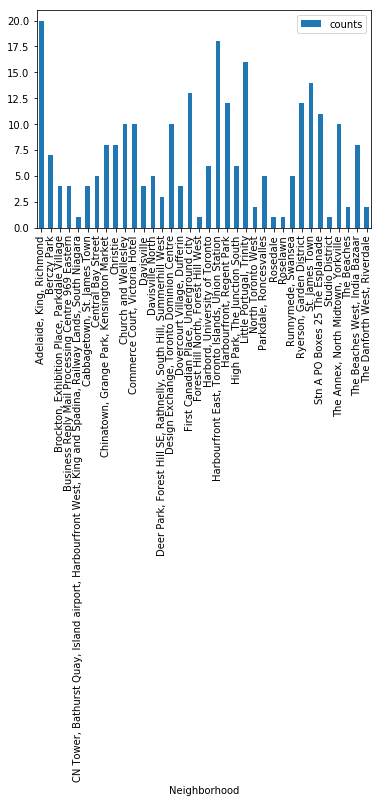

In [43]:
#Bar plot of the amount of Arts & Entertainment venues per neighborhood
art_counts_df.plot.bar()

In [47]:
art = Toronto_Data.set_index('Neighborhood').join(art_counts_df)
art.head()

,PostalCode,Borough,Latitude,Longitude,counts
Neighborhood,,,,,
The Beaches,M4E,East Toronto,43.676357,-79.293031,2.0
"The Danforth West, Riverdale",M4K,East Toronto,43.679557,-79.352188,2.0
"The Beaches West, India Bazaar",M4L,East Toronto,43.668999,-79.315572,8.0
Studio District,M4M,East Toronto,43.659526,-79.340923,1.0
Lawrence Park,M4N,Central Toronto,43.728020,-79.388790,NaN


In [48]:
art = art.rename(index=str, columns={"counts": "Total Art & Entertainment venues"})
art.head()

,PostalCode,Borough,Latitude,Longitude,Total Art & Entertainment venues
Neighborhood,,,,,
The Beaches,M4E,East Toronto,43.676357,-79.293031,2.0
"The Danforth West, Riverdale",M4K,East Toronto,43.679557,-79.352188,2.0
"The Beaches West, India Bazaar",M4L,East Toronto,43.668999,-79.315572,8.0
Studio District,M4M,East Toronto,43.659526,-79.340923,1.0
Lawrence Park,M4N,Central Toronto,43.728020,-79.388790,NaN


# get food venues

In [49]:
#Create a function to get nearby venues from neighbourhoods
def getNearbyFoodVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        
        # 4d4b7105d754a06374d81259,4d4b7104d754a06370d81259,4d4b7105d754a06376d81259
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [50]:
Toronto_food_venues = getNearbyFoodVenues(names=Toronto_Data['Neighborhood'],
                                   latitudes=Toronto_Data['Latitude'],
                                   longitudes=Toronto_Data['Longitude']
                                  )


The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

In [52]:
Toronto_food_venues['Type'] = 'Food'

In [53]:
print(Toronto_food_venues.shape)
Toronto_food_venues.head()

(1346, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Type
0,The Beaches,43.676357,-79.293031,My Bbq,43.676881,-79.289286,BBQ Joint,Food
1,The Beaches,43.676357,-79.293031,Domino's Pizza,43.679058,-79.297382,Pizza Place,Food
2,The Beaches,43.676357,-79.293031,Fearless Meat,43.680337,-79.290289,Burger Joint,Food
3,The Beaches,43.676357,-79.293031,Seaspray Restaurant,43.678888,-79.298167,Asian Restaurant,Food
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant,Food


In [54]:
# i saved the dataframe as csv so i won't need to call foursquare many times
Toronto_food_venues.to_csv('Torontofoodvenues.csv', index=False)

In [55]:
# Sum how many Food venues are in each neighborhood
food_counts_df = pd.DataFrame(Toronto_food_venues.groupby('Neighborhood').size().rename('counts'))

food_counts_df.sort_values(by=['counts'], ascending=False)

,counts
Neighborhood,
"Design Exchange, Toronto Dominion Centre",100
Stn A PO Boxes 25 The Esplanade,100
"Commerce Court, Victoria Hotel",100
"First Canadian Place, Underground city",100
"Adelaide, King, Richmond",95
"Ryerson, Garden District",89
St. James Town,83
"Harbourfront East, Toronto Islands, Union Station",69
Central Bay Street,67


In [56]:
art_food = art.join(food_counts_df)
art_food.head()

,PostalCode,Borough,Latitude,Longitude,Total Art & Entertainment venues,counts
Neighborhood,,,,,,
The Beaches,M4E,East Toronto,43.676357,-79.293031,2.0,4.0
"The Danforth West, Riverdale",M4K,East Toronto,43.679557,-79.352188,2.0,37.0
"The Beaches West, India Bazaar",M4L,East Toronto,43.668999,-79.315572,8.0,11.0
Studio District,M4M,East Toronto,43.659526,-79.340923,1.0,25.0
Lawrence Park,M4N,Central Toronto,43.728020,-79.388790,NaN,1.0


In [57]:
art_food = art_food.rename(index=str, columns={"counts": "Total Food venues"})
art_food.head()

,PostalCode,Borough,Latitude,Longitude,Total Art & Entertainment venues,Total Food venues
Neighborhood,,,,,,
The Beaches,M4E,East Toronto,43.676357,-79.293031,2.0,4.0
"The Danforth West, Riverdale",M4K,East Toronto,43.679557,-79.352188,2.0,37.0
"The Beaches West, India Bazaar",M4L,East Toronto,43.668999,-79.315572,8.0,11.0
Studio District,M4M,East Toronto,43.659526,-79.340923,1.0,25.0
Lawrence Park,M4N,Central Toronto,43.728020,-79.388790,NaN,1.0


# get night life venues

In [58]:
#Create a function to get nearby venues from neighbourhoods
def getNearbyNightVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        
        # 4d4b7105d754a06374d81259,4d4b7104d754a06370d81259,4d4b7105d754a06376d81259
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?categoryId=4d4b7105d754a06376d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [59]:
Toronto_night_venues = getNearbyNightVenues(names=Toronto_Data['Neighborhood'],
                                   latitudes=Toronto_Data['Latitude'],
                                   longitudes=Toronto_Data['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

In [60]:
Toronto_night_venues['Type'] = 'Nightlife Spot'

In [61]:
print(Toronto_night_venues.shape)
Toronto_night_venues.head()

(565, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Type
0,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub,Nightlife Spot
1,"The Danforth West, Riverdale",43.679557,-79.352188,Louis Cifer Brew Works,43.677663,-79.351313,Brewery,Nightlife Spot
2,"The Danforth West, Riverdale",43.679557,-79.352188,The Auld Spot Pub,43.677335,-79.353130,Pub,Nightlife Spot
3,"The Danforth West, Riverdale",43.679557,-79.352188,Bar Oak,43.677931,-79.348724,Lounge,Nightlife Spot
4,"The Danforth West, Riverdale",43.679557,-79.352188,Brass Taps Pizza Pub,43.677924,-79.349307,Sports Bar,Nightlife Spot


In [62]:
# i saved the dataframe as csv so i won't need to call foursquare many times
Toronto_night_venues.to_csv('Torontonightvenues.csv', index=False)

In [63]:
# Sum how many Arts & Entertainment venues are in each neighborhood
night_counts_df = pd.DataFrame(Toronto_night_venues.groupby('Neighborhood').size().rename('counts'))

night_counts_df.sort_values(by=['counts'], ascending=False)

,counts
Neighborhood,
"Commerce Court, Victoria Hotel",60
"First Canadian Place, Underground city",51
"Design Exchange, Toronto Dominion Centre",50
St. James Town,44
Stn A PO Boxes 25 The Esplanade,42
"Adelaide, King, Richmond",40
"Ryerson, Garden District",34
"Harbourfront East, Toronto Islands, Union Station",32
Church and Wellesley,29


In [64]:
art_food_night = art_food.join(night_counts_df)
art_food_night.head()

,PostalCode,Borough,Latitude,Longitude,Total Art & Entertainment venues,Total Food venues,counts
Neighborhood,,,,,,,
The Beaches,M4E,East Toronto,43.676357,-79.293031,2.0,4.0,1.0
"The Danforth West, Riverdale",M4K,East Toronto,43.679557,-79.352188,2.0,37.0,9.0
"The Beaches West, India Bazaar",M4L,East Toronto,43.668999,-79.315572,8.0,11.0,5.0
Studio District,M4M,East Toronto,43.659526,-79.340923,1.0,25.0,8.0
Lawrence Park,M4N,Central Toronto,43.728020,-79.388790,NaN,1.0,NaN


In [68]:
art_food_night = art_food_night.rename(index=str, columns={"counts": "Total Nightlife spots"})
art_food_night.head()

,PostalCode,Borough,Latitude,Longitude,Total Art & Entertainment venues,Total Food venues,Total Nightlife spots
Neighborhood,,,,,,,
The Beaches,M4E,East Toronto,43.676357,-79.293031,2.0,4.0,1.0
"The Danforth West, Riverdale",M4K,East Toronto,43.679557,-79.352188,2.0,37.0,9.0
"The Beaches West, India Bazaar",M4L,East Toronto,43.668999,-79.315572,8.0,11.0,5.0
Studio District,M4M,East Toronto,43.659526,-79.340923,1.0,25.0,8.0
Lawrence Park,M4N,Central Toronto,43.728020,-79.388790,NaN,1.0,NaN


## Get hotels

In [74]:
#Create a function to get nearby Hotels from neighbourhoods
def getNearbyHotelVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?categoryId=4bf58dd8d48988d1fa931735&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [75]:
Toronto_hotel_venues = getNearbyHotelVenues(names=Toronto_Data['Neighborhood'],
                                   latitudes=Toronto_Data['Latitude'],
                                   longitudes=Toronto_Data['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

In [76]:
Toronto_hotel_venues['Type'] = 'Hotel'

In [77]:
print(Toronto_hotel_venues.shape)
Toronto_hotel_venues.head()

(193, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Type
0,"The Beaches West, India Bazaar",43.668999,-79.315572,Days Inn,43.667145,-79.313179,Hotel,Hotel
1,Davisville North,43.712751,-79.390197,Best Western Roehampton Hotel & Suites,43.708878,-79.390880,Hotel,Hotel
2,Davisville North,43.712751,-79.390197,The Ambassador,43.710418,-79.391860,Hotel,Hotel
3,Church and Wellesley,43.665860,-79.383160,Holiday Inn Toronto Downtown Centre,43.661779,-79.381047,Hotel,Hotel
4,Church and Wellesley,43.665860,-79.383160,Town Inn Suites,43.669056,-79.382573,Hotel,Hotel


In [78]:
# i saved the dataframe as csv so i won't need to call foursquare many times
Toronto_hotel_venues.to_csv('Torontohotels.csv', index=False)

In [79]:
# Sum how many Arts & Entertainment venues are in each neighborhood
hotel_counts_df = pd.DataFrame(Toronto_hotel_venues.groupby('Neighborhood').size().rename('counts'))

hotel_counts_df.sort_values(by=['counts'], ascending=False)

,counts
Neighborhood,
"Design Exchange, Toronto Dominion Centre",32
"Commerce Court, Victoria Hotel",28
"First Canadian Place, Underground city",28
"Adelaide, King, Richmond",17
"Ryerson, Garden District",17
St. James Town,15
Stn A PO Boxes 25 The Esplanade,11
Central Bay Street,9
"Chinatown, Grange Park, Kensington Market",9


In [80]:
toronto_final = art_food_night.join(hotel_counts_df)
toronto_final.head()

,PostalCode,Borough,Latitude,Longitude,Total Art & Entertainment venues,Total Food venues,Total Nightlife spots,counts
Neighborhood,,,,,,,,
The Beaches,M4E,East Toronto,43.676357,-79.293031,2.0,4.0,1.0,NaN
"The Danforth West, Riverdale",M4K,East Toronto,43.679557,-79.352188,2.0,37.0,9.0,NaN
"The Beaches West, India Bazaar",M4L,East Toronto,43.668999,-79.315572,8.0,11.0,5.0,1.0
Studio District,M4M,East Toronto,43.659526,-79.340923,1.0,25.0,8.0,NaN
Lawrence Park,M4N,Central Toronto,43.728020,-79.388790,NaN,1.0,NaN,NaN


In [81]:
toronto_final = toronto_final.rename(index=str, columns={"counts": "Total Hotels"})
toronto_final

,PostalCode,Borough,Latitude,Longitude,Total Art & Entertainment venues,Total Food venues,Total Nightlife spots,Total Hotels
Neighborhood,,,,,,,,
The Beaches,M4E,East Toronto,43.676357,-79.293031,2.0,4.0,1.0,NaN
"The Danforth West, Riverdale",M4K,East Toronto,43.679557,-79.352188,2.0,37.0,9.0,NaN
"The Beaches West, India Bazaar",M4L,East Toronto,43.668999,-79.315572,8.0,11.0,5.0,1.0
Studio District,M4M,East Toronto,43.659526,-79.340923,1.0,25.0,8.0,NaN
Lawrence Park,M4N,Central Toronto,43.728020,-79.388790,NaN,1.0,NaN,NaN
Davisville North,M4P,Central Toronto,43.712751,-79.390197,5.0,6.0,NaN,2.0
North Toronto West,M4R,Central Toronto,43.715383,-79.405678,2.0,8.0,NaN,NaN
Davisville,M4S,Central Toronto,43.704324,-79.388790,4.0,34.0,4.0,NaN
"Moore Park, Summerhill East",M4T,Central Toronto,43.689574,-79.383160,NaN,2.0,NaN,NaN


In [82]:
toronto_final = toronto_final.reset_index()
toronto_final

,Neighborhood,PostalCode,Borough,Latitude,Longitude,Total Art & Entertainment venues,Total Food venues,Total Nightlife spots,Total Hotels
0,The Beaches,M4E,East Toronto,43.676357,-79.293031,2.0,4.0,1.0,NaN
1,"The Danforth West, Riverdale",M4K,East Toronto,43.679557,-79.352188,2.0,37.0,9.0,NaN
2,"The Beaches West, India Bazaar",M4L,East Toronto,43.668999,-79.315572,8.0,11.0,5.0,1.0
3,Studio District,M4M,East Toronto,43.659526,-79.340923,1.0,25.0,8.0,NaN
4,Lawrence Park,M4N,Central Toronto,43.728020,-79.388790,NaN,1.0,NaN,NaN
5,Davisville North,M4P,Central Toronto,43.712751,-79.390197,5.0,6.0,NaN,2.0
6,North Toronto West,M4R,Central Toronto,43.715383,-79.405678,2.0,8.0,NaN,NaN
7,Davisville,M4S,Central Toronto,43.704324,-79.388790,4.0,34.0,4.0,NaN
8,"Moore Park, Summerhill East",M4T,Central Toronto,43.689574,-79.383160,NaN,2.0,NaN,NaN
9,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",M4V,Central Toronto,43.686412,-79.400049,3.0,7.0,3.0,NaN


In [83]:
toronto_final.fillna(value=0, inplace=True)
toronto_final

,Neighborhood,PostalCode,Borough,Latitude,Longitude,Total Art & Entertainment venues,Total Food venues,Total Nightlife spots,Total Hotels
0,The Beaches,M4E,East Toronto,43.676357,-79.293031,2.0,4.0,1.0,0.0
1,"The Danforth West, Riverdale",M4K,East Toronto,43.679557,-79.352188,2.0,37.0,9.0,0.0
2,"The Beaches West, India Bazaar",M4L,East Toronto,43.668999,-79.315572,8.0,11.0,5.0,1.0
3,Studio District,M4M,East Toronto,43.659526,-79.340923,1.0,25.0,8.0,0.0
4,Lawrence Park,M4N,Central Toronto,43.728020,-79.388790,0.0,1.0,0.0,0.0
5,Davisville North,M4P,Central Toronto,43.712751,-79.390197,5.0,6.0,0.0,2.0
6,North Toronto West,M4R,Central Toronto,43.715383,-79.405678,2.0,8.0,0.0,0.0
7,Davisville,M4S,Central Toronto,43.704324,-79.388790,4.0,34.0,4.0,0.0
8,"Moore Park, Summerhill East",M4T,Central Toronto,43.689574,-79.383160,0.0,2.0,0.0,0.0
9,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",M4V,Central Toronto,43.686412,-79.400049,3.0,7.0,3.0,0.0


In [84]:
toronto_final1 = toronto_final.drop(['PostalCode', 'Borough', 'Latitude', 'Longitude'], axis=1)
toronto_final1.head()

,Neighborhood,Total Art & Entertainment venues,Total Food venues,Total Nightlife spots,Total Hotels
0,The Beaches,2.0,4.0,1.0,0.0
1,"The Danforth West, Riverdale",2.0,37.0,9.0,0.0
2,"The Beaches West, India Bazaar",8.0,11.0,5.0,1.0
3,Studio District,1.0,25.0,8.0,0.0
4,Lawrence Park,0.0,1.0,0.0,0.0


In [85]:
# i saved the dataframe as csv so i won't need to call foursquare many times
toronto_final.to_csv('Torontofinal.csv', index=False)

## Create a data frame showing total venues from each type by neighborhoods

In [86]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

## Elbow Curve to find the optimum number of clusters

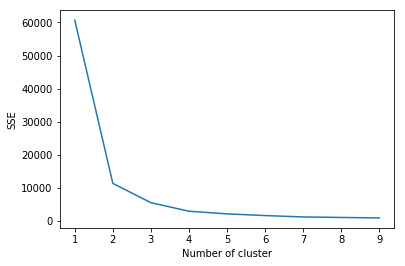

In [87]:
toronto_final_clustering = toronto_final1.drop('Neighborhood', 1)
sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(toronto_final_clustering)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [88]:
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_final_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [89]:
toronto_final['Cluster Labels'] = kmeans.labels_
toronto_final

,Neighborhood,PostalCode,Borough,Latitude,Longitude,Total Art & Entertainment venues,Total Food venues,Total Nightlife spots,Total Hotels,Cluster Labels
0,The Beaches,M4E,East Toronto,43.676357,-79.293031,2.0,4.0,1.0,0.0,0
1,"The Danforth West, Riverdale",M4K,East Toronto,43.679557,-79.352188,2.0,37.0,9.0,0.0,0
2,"The Beaches West, India Bazaar",M4L,East Toronto,43.668999,-79.315572,8.0,11.0,5.0,1.0,0
3,Studio District,M4M,East Toronto,43.659526,-79.340923,1.0,25.0,8.0,0.0,0
4,Lawrence Park,M4N,Central Toronto,43.728020,-79.388790,0.0,1.0,0.0,0.0,0
5,Davisville North,M4P,Central Toronto,43.712751,-79.390197,5.0,6.0,0.0,2.0,0
6,North Toronto West,M4R,Central Toronto,43.715383,-79.405678,2.0,8.0,0.0,0.0,0
7,Davisville,M4S,Central Toronto,43.704324,-79.388790,4.0,34.0,4.0,0.0,0
8,"Moore Park, Summerhill East",M4T,Central Toronto,43.689574,-79.383160,0.0,2.0,0.0,0.0,0
9,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",M4V,Central Toronto,43.686412,-79.400049,3.0,7.0,3.0,0.0,0


In [90]:
#Get the coordinates for Toronto
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [91]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)
import matplotlib.colors as colors
# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map
markers_colors = []
for lat, lon, nei , cluster in zip(toronto_final['Latitude'], toronto_final['Longitude'], toronto_final['Neighborhood'], toronto_final['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#ff0000']


In [92]:
df1=toronto_final.loc[toronto_final['Cluster Labels'] == 0,toronto_final.columns[[0,3,4] + list(range(5, toronto_final.shape[1]))]]
df1

,Neighborhood,Latitude,Longitude,Total Art & Entertainment venues,Total Food venues,Total Nightlife spots,Total Hotels,Cluster Labels
0,The Beaches,43.676357,-79.293031,2.0,4.0,1.0,0.0,0
1,"The Danforth West, Riverdale",43.679557,-79.352188,2.0,37.0,9.0,0.0,0
2,"The Beaches West, India Bazaar",43.668999,-79.315572,8.0,11.0,5.0,1.0,0
3,Studio District,43.659526,-79.340923,1.0,25.0,8.0,0.0,0
4,Lawrence Park,43.728020,-79.388790,0.0,1.0,0.0,0.0,0
5,Davisville North,43.712751,-79.390197,5.0,6.0,0.0,2.0,0
6,North Toronto West,43.715383,-79.405678,2.0,8.0,0.0,0.0,0
7,Davisville,43.704324,-79.388790,4.0,34.0,4.0,0.0,0
8,"Moore Park, Summerhill East",43.689574,-79.383160,0.0,2.0,0.0,0.0,0
9,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049,3.0,7.0,3.0,0.0,0


In [113]:
#Bar plot of the amount of Arts & Entertainment venues per neighborhood
cluster0 = df1.drop(['Latitude', 'Longitude', 'Cluster Labels'], axis=1)
cluster0.head()

,Neighborhood,Total Art & Entertainment venues,Total Food venues,Total Nightlife spots,Total Hotels
0,The Beaches,2.0,4.0,1.0,0.0
1,"The Danforth West, Riverdale",2.0,37.0,9.0,0.0
2,"The Beaches West, India Bazaar",8.0,11.0,5.0,1.0
3,Studio District,1.0,25.0,8.0,0.0
4,Lawrence Park,0.0,1.0,0.0,0.0


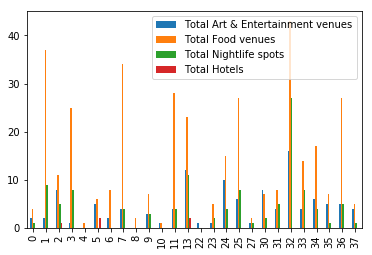

In [114]:
#Explore cluster 0
cluster0.plot.bar()

In [93]:
df2=toronto_final.loc[toronto_final['Cluster Labels'] == 1,toronto_final.columns[[0,3,4] + list(range(5, toronto_final.shape[1]))]]
df2

,Neighborhood,Latitude,Longitude,Total Art & Entertainment venues,Total Food venues,Total Nightlife spots,Total Hotels,Cluster Labels
12,Church and Wellesley,43.665860,-79.383160,10.0,64.0,29.0,9.0,1
14,"Ryerson, Garden District",43.657162,-79.378937,12.0,89.0,34.0,17.0,1
15,St. James Town,43.651494,-79.375418,14.0,83.0,44.0,15.0,1
16,Berczy Park,43.644771,-79.373306,7.0,52.0,28.0,4.0,1
17,Central Bay Street,43.657952,-79.387383,5.0,67.0,16.0,9.0,1
18,"Adelaide, King, Richmond",43.650571,-79.384568,20.0,95.0,40.0,17.0,1
19,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,18.0,69.0,32.0,9.0,1
20,"Design Exchange, Toronto Dominion Centre",43.647177,-79.381576,10.0,100.0,50.0,32.0,1
21,"Commerce Court, Victoria Hotel",43.648198,-79.379817,10.0,100.0,60.0,28.0,1
26,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049,8.0,63.0,26.0,9.0,1


In [115]:
#Bar plot of the amount of Arts & Entertainment venues per neighborhood
cluster1 = df2.drop(['Latitude', 'Longitude', 'Cluster Labels'], axis=1)
cluster1.head()

,Neighborhood,Total Art & Entertainment venues,Total Food venues,Total Nightlife spots,Total Hotels
16,Berczy Park,7.0,52.0,28.0,4.0
12,Church and Wellesley,10.0,64.0,29.0,9.0
17,Central Bay Street,5.0,67.0,16.0,9.0
19,"Harbourfront East, Toronto Islands, Union Station",18.0,69.0,32.0,9.0
26,"Chinatown, Grange Park, Kensington Market",8.0,63.0,26.0,9.0


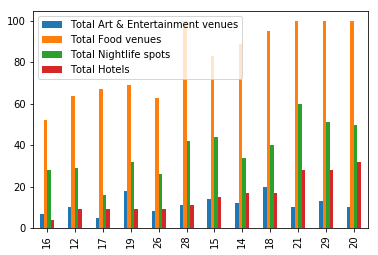

In [116]:
#Explore cluster 1
cluster1.plot.bar()

In [94]:
df2.sort_values(by=['Total Hotels'], ascending=True, inplace=True)

In [95]:
best = df2.head()
best

,Neighborhood,Latitude,Longitude,Total Art & Entertainment venues,Total Food venues,Total Nightlife spots,Total Hotels,Cluster Labels
16,Berczy Park,43.644771,-79.373306,7.0,52.0,28.0,4.0,1
12,Church and Wellesley,43.665860,-79.383160,10.0,64.0,29.0,9.0,1
17,Central Bay Street,43.657952,-79.387383,5.0,67.0,16.0,9.0,1
19,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,18.0,69.0,32.0,9.0,1
26,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049,8.0,63.0,26.0,9.0,1


In [96]:
best = best.reset_index(drop=True)
best

,Neighborhood,Latitude,Longitude,Total Art & Entertainment venues,Total Food venues,Total Nightlife spots,Total Hotels,Cluster Labels
0,Berczy Park,43.644771,-79.373306,7.0,52.0,28.0,4.0,1
1,Church and Wellesley,43.665860,-79.383160,10.0,64.0,29.0,9.0,1
2,Central Bay Street,43.657952,-79.387383,5.0,67.0,16.0,9.0,1
3,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,18.0,69.0,32.0,9.0,1
4,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049,8.0,63.0,26.0,9.0,1


In [97]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14)
import matplotlib.colors as colors
# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map
markers_colors = []
for lat, lon, nei , cluster in zip(best['Latitude'], best['Longitude'], best['Neighborhood'], best['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#ff0000']


#### The result recommendation for 5 optional neighborhoods to start a new hotel is displayed on map

In [106]:
#Bar plot of the amount of Arts & Entertainment venues per neighborhood
bestplot = best.drop(['Latitude', 'Longitude', 'Cluster Labels'], axis=1)
bestplot

,Neighborhood,Total Art & Entertainment venues,Total Food venues,Total Nightlife spots,Total Hotels
0,Berczy Park,7.0,52.0,28.0,4.0
1,Church and Wellesley,10.0,64.0,29.0,9.0
2,Central Bay Street,5.0,67.0,16.0,9.0
3,"Harbourfront East, Toronto Islands, Union Station",18.0,69.0,32.0,9.0
4,"Chinatown, Grange Park, Kensington Market",8.0,63.0,26.0,9.0


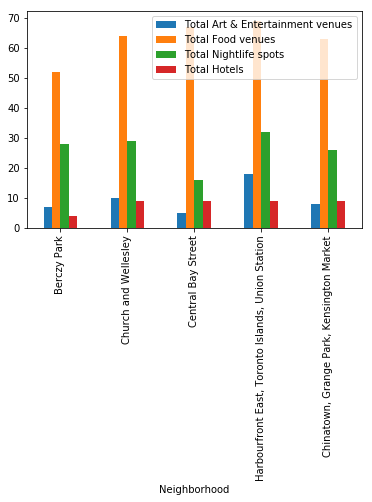

In [111]:
#Explore the 5 recommendations
bestplot.plot.bar(x='Neighborhood')

further explanations and observations are discussed in the report
I hope you enjoyed this project !!